# Trabalho 3

Esse notebook serve como base para o desenvolvimento da Trabalho 3, e deve ser submetido após a conclusão das atividades propostas. 

Neste trabalho, iremos utilizar uma Rede Generativa Adversarial (GAN) para gerar dígitos de casas do *dataset* SVHN (*Street View House Numbers*). GANs são formadas por duas redes (discriminador e gerador) que são treinadas simultaneamente, sem compartilhamento de pesos. O gerador é responsável por aprender a transformar um ruído aleatório em uma imagem do *dataset* de interesse, enquanto o discriminador é responsável por classificar as imagens em reais e sintéticas (geradas). 

Abaixo, incluímos alguns imports, e mostramos uma maneira de processar o arquivo `train_32x32.mat` (pode ser baixado [aqui](http://ufldl.stanford.edu/housenumbers/train_32x32.mat)) que contém as imagens do dataset [SVHN](http://ufldl.stanford.edu/housenumbers/).

Sugerimos que o código da prática 8 seja estudado, e o mesmo **pode** servir de base para este trabalho, já que o procedimento de treino da GAN não muda.

## Depois de cada atividade, inclua uma breve análise do que foi feito e dos resultados!

# Imports
Vamos importar as dependências necessárias!

In [4]:
from __future__ import print_function, division

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist

import sys
import matplotlib.pyplot as plt
import numpy as np

from scipy.io import loadmat

In [5]:
# Caso queira carregar os dados do drive, descomente as linhas seguintes:
#from google.colab import drive
#drive.mount('/content/gdrive')

# Carregue o dataset SVHN

Os dados são fornecidos em um arquivo .mat, que armazena um dicionário.

Para acessar os dados armazenados, utilizamos a função `loadmat` do pacote `scipy`.  Para acessar as imagens, acessamos o campo `['X']` desse dicionário. Um exemplo é mostrado abaixo:

Obs.: Lembre-se que para o Keras usando Tensorflow como backend, a dimensão dos canais deve ser a última do seu vetor.

(73257, 32, 32, 3)


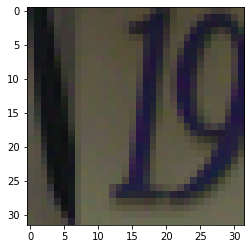

In [6]:
# Load the dataset
X_train = loadmat('./train_32x32.mat')['X']

X_train = np.moveaxis(X_train, -1, 0)
print(X_train.shape)

plt.imshow(X_train[0])


# Vanilla GAN com o SVHN
A rede mostrada na prática 8 gerava os dígitos do MNIST utilizando camadas densas. Apesar de também conter dígitos, o SVHN possui imagens maiores (32x32), e 3 canais (RGB). Essas diferenças fazem com que a rede precise ser levemente adaptada para poder trabalhar com o novo dataset e gerar novas amostras.

Portanto, altere o código da prática 8 para gerar dados do dataset SVHN com as camadas Densas da 'Vanilla' GAN, e mostre os resultados. A 'Vanilla' GAN conseguiu gerar as imagens do (mais complexo) dataset SVHN?


In [53]:
def build_generator(latent_dim, img_shape):
  model = Sequential()

  model.add(layers.Dense(256, input_dim=latent_dim))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.BatchNormalization(momentum=0.8))
  model.add(layers.Dense(512))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.BatchNormalization(momentum=0.8))
  model.add(layers.Dense(1024))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.BatchNormalization(momentum=0.8))
  model.add(layers.Dense(np.prod(img_shape), activation='tanh'))
  model.add(layers.Reshape(img_shape))

  #model.summary()

  noise = layers.Input(shape=(latent_dim,))
  img = model(noise)

  return Model(noise, img)

def build_discriminator(img_shape):

  model = Sequential()

  model.add(layers.Flatten(input_shape=img_shape))
  model.add(layers.Dense(512))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dense(256))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Dense(1, activation='sigmoid'))
  #model.summary()

  img = layers.Input(shape=img_shape)
  validity = model(img)

  return Model(img, validity)

def sample_images(iter, generator):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Re-escale as imagens para [0, 1] para plotar.
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:])
            axs[i,j].axis('off')
            cnt += 1
    plt.show()
    plt.close()

In [54]:
img_shape = (32, 32, 3)
latent_dim = 100

optimizer = Adam(0.0002, 0.5)

# Constrói e compila o discriminador
discriminator = build_discriminator(img_shape)
discriminator.summary()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])


# Constrói o gerador
generator = build_generator(latent_dim, img_shape)

# O gerador recebe ruído aleatório como entrada, e retorna imagens como saída
z = layers.Input(shape=(latent_dim,))
img = generator(z)

# Para o modelo combinado, treinamos apenas o gerador
discriminator.trainable = False

# O discriminador recebe imagens geradas e reais como entrada, e as classifica entre essas duas classes.
validity = discriminator(img)

# O modelo combinado (gerador e discriminador) é utilizado para treinar o gerador a "enganar" o discriminador.
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
print(combined.summary())

Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_28 (Sequential)   (None, 1)                 1704961   
Total params: 1,704,961
Trainable params: 1,704,961
Non-trainable params: 0
_________________________________________________________________
Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        [(None, 100)]             0         
_________________________________________________________________
model_35 (Functional)        (None, 32, 32, 3)         3838720   
_________________________________________________________________
model_34 (Functional)        (None, 1)                 1704961   
Total params: 5,543,681
Traina

In [55]:
batch_size=64

# Ground truth para treinamento. Reais -> 1; Sintéticas (falsas) -> 0
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

0 [D loss: 0.369182, acc.: 59.38%] [G loss: 0.634382]


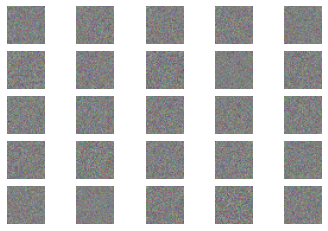

5000 [D loss: 0.001018, acc.: 100.00%] [G loss: 6.203107]


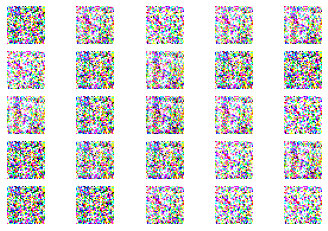

10000 [D loss: 72.741653, acc.: 50.00%] [G loss: 0.000000]


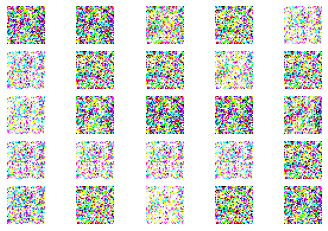

15000 [D loss: 0.000010, acc.: 100.00%] [G loss: 10.840248]


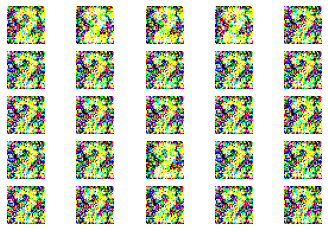

20000 [D loss: 0.025406, acc.: 99.22%] [G loss: 4.490047]


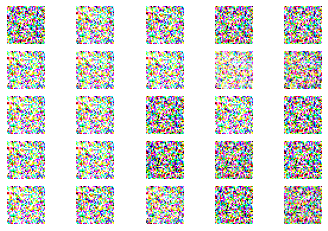

In [56]:
iterations=25000
sample_interval=5000
batch_size=64
for iter in range(iterations):

  # ---------------------
  #  Treino do Discriminador
  # ---------------------

  # Selecione um batch aleatório de imagens
  idx = np.random.choice(X_train.shape[0], batch_size, replace=False)
  imgs = X_train[idx]

  noise = np.random.normal(0, 1, (batch_size, latent_dim))

  # Gere um batch de imagens sintéticas.
  gen_imgs = generator.predict(noise)

  # Treine o discriminador:
  #    Com imagens reais
  d_loss_real = discriminator.train_on_batch(imgs, valid)
  #    Com imagens sintéticas:
  d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
  # Faça a média das duas.
  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

  # ---------------------
  #  Treino do Gerador
  # ---------------------

  # Amostragem de um ruído aleatório
  noise = np.random.normal(0, 1, (batch_size, latent_dim))

  # Treine o gerador, de forma a enganar o discriminador (tentar fazer que ele as classifique as imagens geradas como reais -> passamos 'valid' como ground truth). 
  # Por esse motivo "congelamos" os pesos do discriminador para esse passo!!!
  g_loss = combined.train_on_batch(noise, valid)

  # Plote o progresso a cada 'sample_interval' iterações
  if iter % sample_interval == 0:
      print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iter, d_loss[0], 100*d_loss[1], g_loss))
      sample_images(iter, generator)

# Arquitetura DCGAN

Defina aqui a arquitetura do gerador e discriminador da DCGAN seguindo o modelo segundo a imagem abaixo:

<img src='https://i.imgur.com/eU2XOxS.png' />

Vamos utilizá-la para gerar os dígitos do SVHN.

In [42]:
def build_generator(latent_dim, img_shape):
  model = Sequential()
  n_nodes = 128 * 8 * 8
  model.add(layers.Dense(n_nodes, input_dim=latent_dim, activation='relu'))
  model.add(layers.Reshape((8, 8, 128)))

  model.add(layers.Conv2DTranspose(128, (3,3), strides=(1,1), padding='same'))
  model.add(layers.BatchNormalization(momentum=0.8))
  model.add(layers.ReLU())

  model.add(layers.Conv2DTranspose(64, (3,3), strides=(1,1), padding='same'))
  model.add(layers.BatchNormalization(momentum=0.8))
  model.add(layers.ReLU())

  model.add(layers.Conv2D(3, (3,3), strides=(1,1), activation='tanh', padding='same'))

  # model.summary()

  noise = layers.Input(shape=(latent_dim))
  img = model(noise)

  return Model(noise, img)

def build_discriminator(img_shape):

  model = Sequential()

  model.add(layers.Conv2D(32, (3,3), strides=(2,2), padding='same', input_shape=img_shape))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.25))
  
  model.add(layers.Conv2D(64, (3,3), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.25))

  model.add(layers.Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.25))

  model.add(layers.Conv2D(256, (3,3), strides=(1,1), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.25))
  
  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))
  
  # model.summary()

  img = layers.Input(shape=img_shape)
  validity = model(img)

  return Model(img, validity)

def sample_images(iter, generator):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)

    # Re-escale as imagens para [0, 1] para plotar.
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:])
            axs[i,j].axis('off')
            cnt += 1
    plt.show()
    plt.close()

# Treine a DCGAN!

Dica: Estude o código mostrado em sala na prática 8, e adapte-o para treinar a DCGAN.

In [43]:
batch_size=64

# Ground truth para treinamento. Reais -> 1; Sintéticas (falsas) -> 0
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

In [44]:
img_shape = (32, 32, 3)
latent_dim = 100

optimizer = Adam(0.0002, 0.5)

# Constrói e compila o discriminador
discriminator = build_discriminator(img_shape)
discriminator.summary()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])


# Constrói o gerador
generator = build_generator(latent_dim, img_shape)

# O gerador recebe ruído aleatório como entrada, e retorna imagens como saída
z = layers.Input(shape=(latent_dim))
img = generator(z)

# Para o modelo combinado, treinamos apenas o gerador
discriminator.trainable = False

# O discriminador recebe imagens geradas e reais como entrada, e as classifica entre essas duas classes.
validity = discriminator(img)

# O modelo combinado (gerador e discriminador) é utilizado para treinar o gerador a "enganar" o discriminador.
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)
print(combined.summary())

Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_22 (Sequential)   (None, 1)                 392513    
Total params: 392,513
Trainable params: 392,513
Non-trainable params: 0
_________________________________________________________________


ValueError: Input 0 of layer dense_27 is incompatible with the layer: expected axis -1 of input shape to have value 4096 but received input with shape (None, 256)

In [32]:
iterations=25000
sample_interval=1000


for iter in range(iterations):

  # ---------------------
  #  Treino do Discriminador
  # ---------------------

  # Selecione um batch aleatório de imagens
  idx = np.random.choice(X_train.shape[0], batch_size, replace=False)
  imgs = X_train[idx]

  noise = np.random.normal(0, 1, (batch_size, latent_dim))

  # Gere um batch de imagens sintéticas.
  gen_imgs = generator.predict(noise)

  # Treine o discriminador:
  #    Com imagens reais
  d_loss_real = discriminator.train_on_batch(imgs, valid)
  #    Com imagens sintéticas:
  d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
  # Faça a média das duas.
  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

  # ---------------------
  #  Treino do Gerador
  # ---------------------

  # Amostragem de um ruído aleatório
  noise = np.random.normal(0, 1, (batch_size, latent_dim))

  # Treine o gerador, de forma a enganar o discriminador (tentar fazer que ele as classifique as imagens geradas como reais -> passamos 'valid' como ground truth). 
  # Por esse motivo "congelamos" os pesos do discriminador para esse passo!!!
  g_loss = combined.train_on_batch(noise, valid)

  # Plote o progresso a cada 'sample_interval' iterações
  if iter % sample_interval == 0:
      print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (iter, d_loss[0], 100*d_loss[1], g_loss))
      sample_images(iter, generator)

2021-11-13 18:47:17.485957: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


ValueError: in user code:

    /usr/local/lib/python3.9/site-packages/keras/engine/training.py:853 train_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.9/site-packages/keras/engine/training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.9/site-packages/keras/engine/training.py:835 run_step  **
        outputs = model.train_step(data)
    /usr/local/lib/python3.9/site-packages/keras/engine/training.py:788 train_step
        loss = self.compiled_loss(
    /usr/local/lib/python3.9/site-packages/keras/engine/compile_utils.py:201 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /usr/local/lib/python3.9/site-packages/keras/losses.py:141 __call__
        losses = call_fn(y_true, y_pred)
    /usr/local/lib/python3.9/site-packages/keras/losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /usr/local/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /usr/local/lib/python3.9/site-packages/keras/losses.py:1809 binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    /usr/local/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /usr/local/lib/python3.9/site-packages/keras/backend.py:5000 binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    /usr/local/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /usr/local/lib/python3.9/site-packages/tensorflow/python/ops/nn_impl.py:245 sigmoid_cross_entropy_with_logits_v2
        return sigmoid_cross_entropy_with_logits(
    /usr/local/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /usr/local/lib/python3.9/site-packages/tensorflow/python/ops/nn_impl.py:132 sigmoid_cross_entropy_with_logits
        raise ValueError("logits and labels must have the same shape (%s vs %s)" %

    ValueError: logits and labels must have the same shape ((64, 4, 4, 1) vs (64, 1))


# Escreva aqui um parágrafo com suas conclusões gerais e análises sobre o experimento proposto.


